Imports

In [1]:
import pandas as pd;
import os;
from google.colab import files;
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
import operator

In [2]:
from google.colab import drive
# for mounting google drive to access training data from
# filepath: /content/drive/MyDrive/Colab Notebooks
drive.mount('/content/drive')

Mounted at /content/drive


Data cleaning

In [3]:
# norm(attr:string)
# apply zscore normalisation on field 'attr'

# continuous_bin(attr:string, bins:int)
# create bins distrubuted by percentile intervals equals to 'bins'. Does not yield specified number of bins
# if data is very skewed.
def norm(dataSet, attr):
    dataSet[attr] = (
        (dataSet[attr] - dataSet[attr].mean())/dataSet[attr].std()
    )
def continuous_bin(dataSet, attr, bins):
    intervals = 1/bins
    percentiles = dataSet[attr].quantile([i*intervals for i in range(0, bins + 1)]).unique()
    bins = list(map(lambda x : float(x), percentiles))


    dataSet[attr] = pd.cut(
        dataSet[attr], bins=bins,
        labels=bins[1:]
        )


In [4]:
# Task 1 (1)
# importing data into dataframes
not_loaded = True
while not_loaded:
    try:
        if "churn_train.csv" in os.listdir():
            churn_train = pd.read_csv("customer_churn_dataset-training-master.csv")
            churn_test = pd.read_csv("customer_churn_dataset-testing-master.csv")
            not_loaded = False
        else:
            churn_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer_churn_dataset-training-master.csv")
            churn_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer_churn_dataset-testing-master.csv")
            not_loaded = False
    except FileNotFoundError as e:
        files.upload()

In [5]:
# Check for the non continuous attributes
for attr in churn_train.columns:
    if len(churn_train[attr].unique()) < 10:
        print(f"{attr}: {churn_train[attr].value_counts()}")

Gender: Gender
Male      250252
Female    190580
Name: count, dtype: int64
Subscription Type: Subscription Type
Standard    149128
Premium     148678
Basic       143026
Name: count, dtype: int64
Contract Length: Contract Length
Annual       177198
Quarterly    176530
Monthly       87104
Name: count, dtype: int64
Churn: Churn
1.0    249999
0.0    190833
Name: count, dtype: int64


In [6]:
gender = {"Female":0, "Male":1}
Sub_type = {"Standard":0, "Basic":1, "Premium":2}
# converted df
conv_churn_train = churn_train.copy()
conv_churn_train["Gender"] = conv_churn_train["Gender"].map(gender)
conv_churn_train["Subscription Type"] = conv_churn_train["Subscription Type"].map(Sub_type)

In [7]:
# Task1 (2)
missing = conv_churn_train.isnull().any(axis=0).sum()
total = len(churn_train.index)
# print((missing / total)*100)
# 0.002% columns are null! There are 9 records that are empty.
# Because the missing data takes up a small portion of the training data I will delete samples with missing data

clean_churn_train = conv_churn_train.copy().dropna()
filled = clean_churn_train.isnull().any(axis=0).sum()
print(f"number of rows with nan:{missing}\nnumber of rows with nan after cleaning:{filled}")

number of rows with nan:12
number of rows with nan after cleaning:0


Pre-processing

In [8]:
# Task 1 (3)
norm(clean_churn_train, "Last Interaction")
variance = clean_churn_train['Last Interaction'].std() ** 2
mean = clean_churn_train['Last Interaction'].mean()
print(f"var{variance:.2e}, mean{mean:.2e}\nApproximately 1 and 0")

var1.00e+00, mean1.04e-16
Approximately 1 and 0


In [9]:
# Task 1 (4)
continuous_bin(clean_churn_train, "Total Spend", 5)
print("Number of rows for each 'Total Spend' quantile:")
print(clean_churn_train['Total Spend'].value_counts().sort_index())

Number of rows for each 'Total Spend' quantile:
Total Spend
405.000     88248
592.774     87985
728.720     88170
863.640     88166
1000.000    88163
Name: count, dtype: int64


In [10]:
# Task 1 (5)
Onehot = pd.get_dummies(clean_churn_train['Contract Length'], prefix='Contract Length')
clean_churn_train = pd.concat([clean_churn_train, Onehot], axis=1)
clean_churn_train.drop('Contract Length', axis=1, inplace=True)

In [11]:
# test_churn_train = clean_churn_train.copy() #COPY HERE FOR TESTING

In [12]:
# Task 1 (6)
# Chose Support calls and Tenure to create secondary attribute Support Call Rate.
# Support calls has the highest correlation coefficient according to the matrix
# Therefore, by extension Support call rate would likely yield similar results

clean_churn_train['Support call rate'] =(
    clean_churn_train['Support Calls']/clean_churn_train['Tenure']
)

In [13]:
correlation_matrix = clean_churn_train.corr()

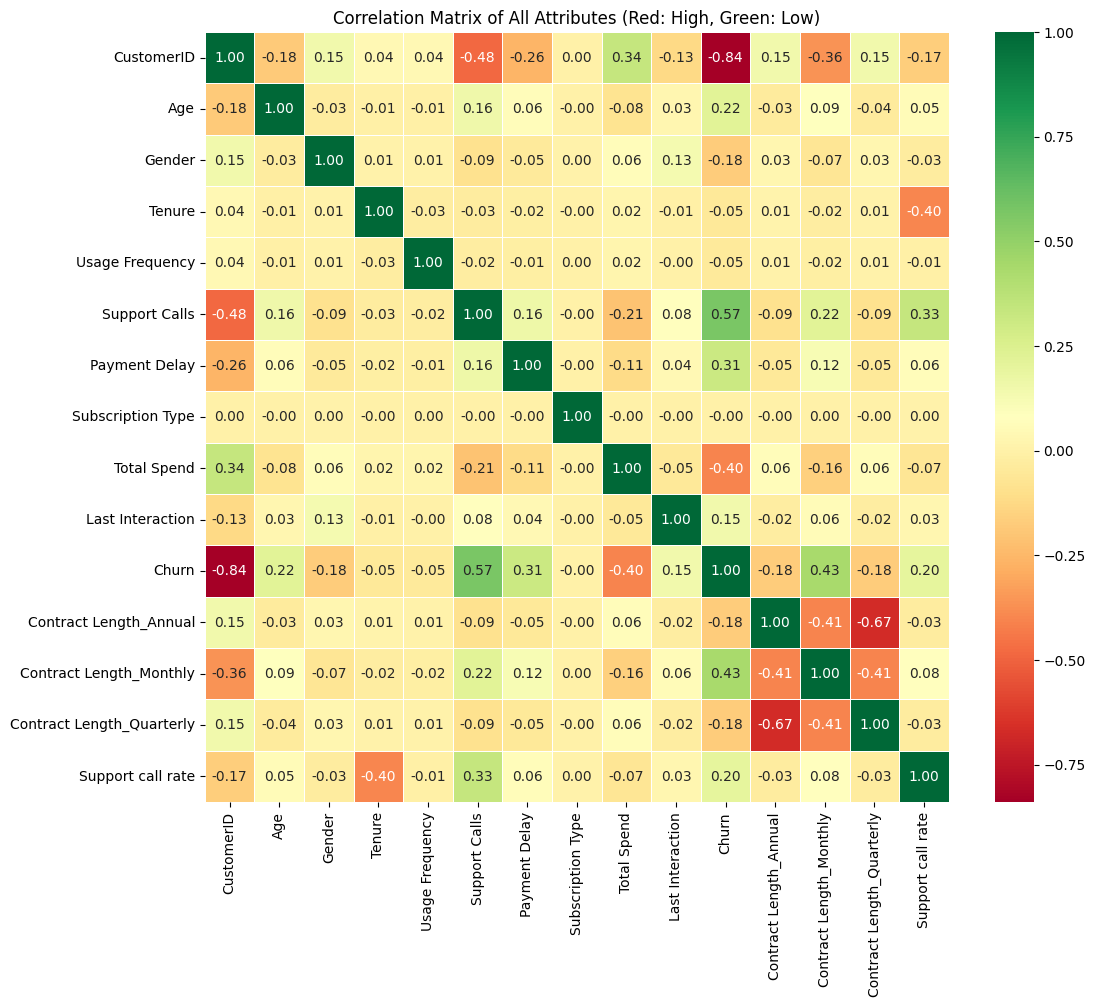

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of All Attributes (Red: High, Green: Low)')
plt.show()

Task 2

In [15]:
#find the continuous columns
continuous_columns = []

for attr in clean_churn_train.columns:
    if len(clean_churn_train[attr].unique()) > 10:
        if attr != "CustomerID":
            continuous_columns.append(attr)
            print(f"{attr}")

Age
Tenure
Usage Frequency
Support Calls
Payment Delay
Last Interaction
Support call rate


In [16]:
# Task 2 (1)
# most pre-processing steps have already been done in part 1.
for attr in continuous_columns:
    continuous_bin(clean_churn_train, attr, 10)

In [17]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2) #log base 2
    return shannonEnt

def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

def chooseBestFeatureToSplit(dataSet):
    print(dataSet)
    # prepruning
    if dataSet.shape < 20:
        return None
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet] #create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
        # prepruning
        if bestInfoGain < 0.01:
            return None
    return bestFeature

def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]#stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree

def classify(inputTree,featLabels,testVec):
    firstStr=list(inputTree.keys())[0]
    secondDict=inputTree[firstStr]
    featIndex=featLabels.index(firstStr)
    for key in secondDict:
        if testVec[featIndex]==key:
            if type(secondDict[key]).__name__=='dict':
                classLabel=classify(secondDict[key],featLabels,testVec)
            else:
                classLabel=secondDict[key]
    return classLabel

calcShannonEnt(dataSet):
Calculates Shannon entropy of the dataset. Measures impurity/uncertainty in class labels. Higher entropy means more mixed classes.

splitDataSet(dataSet, axis, value):
Splits dataset by a specific feature (axis) with a given value. Returns subset where feature equals value, removing that feature column.

chooseBestFeatureToSplit(dataSet):
Finds feature with highest information gain. Compares entropy reduction for all features. Returns index of best splitting feature.

majorityCnt(classList):
Determines most frequent class in a list. Used when no more splits are possible or for tie-breaking.

createTree(dataSet, labels):
Recursively builds decision tree using ID3 algorithm. Stops when pure classes or no features remain. Returns tree structure.

classify(inputTree, featLabels, testVec):
Traverses decision tree to classify a test sample. Follows feature branches based on test values until reaching leaf node.

I chose to perform pre-pruning to avoid overfitting during the induction of a decision tree

pre-pruning halting tree construction early, it prevents the model from developing too many branches that may merely reflect anomalies, noise, or outliers in the training data

within chooseBestFeatureToSplit i set two threshold for halting.
When the size of the split dataset is less than 20.
When the decrease in entropy\(variance\) is less than 0.1.

In [ ]:
Decision_Tree = createTree(clean_churn_train.values.tolist(), clean_churn_train.columns.tolist())